In [1]:
using ParallelTemperingMonteCarlo
using Random


Having made breaking changes to the operation of the ptmc_run function, it's time to begin an extensive process of testing and measuring to ensure consistency in results

In [2]:
Random.seed!(1234)

# number of atoms
n_atoms = 13

# temperature grid
ti = 5.
tf = 16.
n_traj = 32

temp = TempGrid{n_traj}(ti,tf) 

# MC simulation details


mc_cycles = 300000 #default 20% equilibration cycles on top


mc_sample = 1  #sample every mc_sample MC cycles

#move_atom=AtomMove(n_atoms) #move strategy (here only atom moves, n_atoms per MC cycle)
displ_atom = 0.1 # Angstrom
n_adjust = 100

max_displ_atom = [0.1*sqrt(displ_atom*temp.t_grid[i]) for i in 1:n_traj]

mc_params = MCParams(mc_cycles, n_traj, n_atoms, mc_sample = mc_sample, n_adjust = n_adjust)

#moves - allowed at present: atom, volume and rotation moves (volume,rotation not yet implemented)
move_strat = MoveStrategy(atom_moves = n_atoms)  

#ensemble
ensemble = NVT(n_atoms)

#ELJpotential for neon
#c1=[-10.5097942564988, 0., 989.725135614556, 0., -101383.865938807, 0., 3918846.12841668, 0., -56234083.4334278, 0., 288738837.441765]
#elj_ne1 = ELJPotential{11}(c1)

c=[-10.5097942564988, 989.725135614556, -101383.865938807, 3918846.12841668, -56234083.4334278, 288738837.441765]
pot = ELJPotentialEven{6}(c)

#starting configurations
#icosahedral ground state of Ne13 (from Cambridge cluster database) in Angstrom
pos_ne13 = [[2.825384495892464, 0.928562467914040, 0.505520149314310],
[2.023342172678102,	-2.136126268595355, 0.666071287554958],
[2.033761811732818,	-0.643989413759464, -2.133000349161121],
[0.979777205108572,	2.312002562803556, -1.671909307631893],
[0.962914279874254,	-0.102326586625353, 2.857083360096907],
[0.317957619634043,	2.646768968413408, 1.412132053672896],
[-2.825388342924982, -0.928563755928189, -0.505520471387560],
[-0.317955944853142, -2.646769840660271, -1.412131825293682],
[-0.979776174195320, -2.312003751825495, 1.671909138648006],
[-0.962916072888105, 0.102326392265998,	-2.857083272537599],
[-2.023340541398004, 2.136128558801072,	-0.666071089291685],
[-2.033762834001679, 0.643989905095452, 2.132999911364582],
[0.000002325340981,	0.000000762100600, 0.000000414930733]]

#convert to Bohr
AtoBohr = 1.8897259886
pos_ne13 = pos_ne13 * AtoBohr

length(pos_ne13) == n_atoms || error("number of atoms and positions not the same - check starting config")

#boundary conditions 
bc_ne13 = SphericalBC(radius=5.32*AtoBohr)   #5.32 Angstrom

#starting configuration
start_config = Config(pos_ne13, bc_ne13)

#histogram information
n_bin = 100
#en_min = -0.006    #might want to update after equilibration run if generated on the fly
#en_max = -0.001    #otherwise will be determined after run as min/max of sampled energies (ham vector)

#construct array of MCState (for each temperature)
mc_states = [MCState(temp.t_grid[i], temp.beta_grid[i], start_config, pot) for i in 1:n_traj]

#results = Output(n_bin, max_displ_vec)
results = Output{Float64}(n_bin; en_min = mc_states[1].en_tot)

Output{Float64}(100, 0.0, 0.0, Float64[], Float64[], Float64[], Vector{Float64}[], Vector{Float64}[], Float64[], Float64[], Float64[], Float64[])

In [3]:
inputs = mc_states,move_strat,mc_params,pot,ensemble,results

(MCState{Float64, 13, SphericalBC{Float64}}[MCState{Float64, 13, SphericalBC{Float64}}(5.0, 63154.997052619445, Config{13, SphericalBC{Float64}, Float64}(StaticArraysCore.SVector{3, Float64}[[5.339202509675499, 1.7547286276557148, 0.9552945639202041], [3.8235622875401982, -4.036693324695786, 1.2586922223528678], [3.8432525502537267, -1.2169635315645375, -4.030786193502644], [1.8515104475315411, 4.369051328639683, -3.1594504692142205], [1.8196441394724319, -0.19336921007065874, 5.399104677171738], [0.6008527770958447, 5.001668105430829, 2.668542641160762], [-5.339209779512827, -1.754731061649526, -0.9552951725503948], [-0.6008496122188508, -5.001669753738395, -2.668542209586626], [-1.851508499387977, -4.369053575565342, 3.1594501498809775], [-1.8196475277773039, 0.19336884278473446, -5.399104511708638], [-3.823559204867802, 4.036697652557049, -1.2586918476896083], [-3.8432544820617607, 1.2169644600549232, 4.030785366187147], [4.394257284152319e-6, 1.4401613097476533e-6, 7.84105389618947

In [5]:
ptmc_run!(inputs ;restart=false, save=true,save_dir = pwd())

equilibration done
equilibration done


MC loop done.


[0.0003243459217939951, 0.0003370075647306786, 0.0003525966901730947, 0.0003780759497309432, 0.00038706273946681024, 0.000413034687123164, 0.00043651439857381164, 0.0004564522740989397, 0.0004901565405939628, 0.0005146705983208746, 0.0005600118159969748, 0.0005872255928882525, 0.0006099754206397523, 0.0006390938761174046, 0.0007325292538147292, 0.0008519127318891778, 0.0009004818502506845, 0.0009880546994410968, 0.001107749070383221, 0.0015662401048997193, 0.001757719903775424, 0.0022311766910410023, 0.002633096741429676, 0.003151856007501464, 0.003400930576340628, 0.003193715048202411, 0.0030254746642045627, 0.0026268717064065862, 0.002408965960466792, 0.0022055856515379255, 0.002101126069933227, 0.001911240547431439]
done


B Vector Calculated
A Matrix Calculated
system solved!
Entropy Found
Quantities found
analysis complete


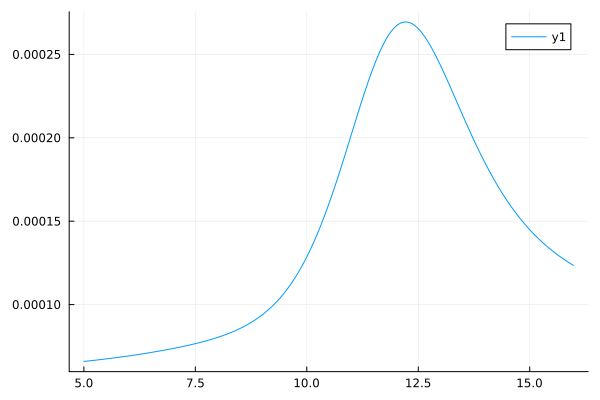

In [6]:
using Plots
plot(temp.t_grid,results.heat_cap)
multihistogram(results,temp)
X = read_multihist()
plot(X[1],X[2])

In [7]:
restart_input = pot,pwd()

ptmc_run!(restart_input;restart=true,save=true)

Total number of moves per MC cycle: 13



equilibration done


MC loop done.


[0.00032000871008821895, 0.0003350710639512663, 0.00034953950201821503, 0.00037539976870578593, 0.0003852835466853568, 0.0004078726304459358, 0.0004314165380692369, 0.0004549520374823486, 0.0004892535926782798, 0.0005159086130459813, 0.0005539889058431495, 0.0005812683333326746, 0.0006127331018510896, 0.0006321684822920467, 0.0007274921271905978, 0.0008164708398022142, 0.0008735581032493738, 0.0009773309747529804, 0.0011467729691919293, 0.0015536286304891954, 0.0018046117316657272, 0.0022821311226032337, 0.002688416974386208, 0.003008222411104273, 0.003307034236190459, 0.003144316822618974, 0.0030943543548784575, 0.002726274949648926, 0.0024659328481901953, 0.002252783351277122, 0.0020940720586646987, 0.0019915831478314284]
done


In [8]:
file=open("test_input.data","w+")
save_params(file,mc_params,move_strat,ensemble)
write(file,"ti,tf: $ti $tf\n")
write(file,"max_displacemet: 0.1 \n")
write(file,"n_bins= 100\n")
write(file, "Boundary: $(typeof(mc_states[1].config.bc))  $(sqrt(mc_states[1].config.bc.radius2)) \n")
write(file,"configuration \n")
for row in start_config.pos
    write(file,"$(row[1]) $(row[2]) $(row[3]) \n")
end
write(file,"end")
close(file)

In [14]:
mc_states,move_strat,mc_params,pot,ensemble,results = init_sim(pot,"$(pwd())/test_input.data",0.2)

MethodError: MethodError: Cannot `convert` an object of type SubString{String} to an object of type Float64
Closest candidates are:
  convert(::Type{T}, !Matched::Base.TwicePrecision) where T<:Number at twiceprecision.jl:273
  convert(::Type{T}, !Matched::AbstractChar) where T<:Number at char.jl:185
  convert(::Type{T}, !Matched::CartesianIndex{1}) where T<:Number at multidimensional.jl:130
  ...

In [10]:
testinput = pot,pwd()

initialisation(false,pot,pwd(),startfile="test_input.data")

MethodError: MethodError: Cannot `convert` an object of type SubString{String} to an object of type Float64
Closest candidates are:
  convert(::Type{T}, !Matched::Base.TwicePrecision) where T<:Number at twiceprecision.jl:273
  convert(::Type{T}, !Matched::AbstractChar) where T<:Number at char.jl:185
  convert(::Type{T}, !Matched::CartesianIndex{1}) where T<:Number at multidimensional.jl:130
  ...

In [9]:
testinput = pot,pwd()
# ptmc_run!(testinput;restart=false,startfile="test_input.data")

MethodError: MethodError: Cannot `convert` an object of type SubString{String} to an object of type Float64
Closest candidates are:
  convert(::Type{T}, !Matched::Base.TwicePrecision) where T<:Number at twiceprecision.jl:273
  convert(::Type{T}, !Matched::AbstractChar) where T<:Number at char.jl:185
  convert(::Type{T}, !Matched::CartesianIndex{1}) where T<:Number at multidimensional.jl:130
  ...